In [ ]:
import json
import os
import random
import statistics

import av
import cv2
from datasets import load_from_disk, concatenate_datasets
import evaluate
import ipyplot
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import transforms as T
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, TimesformerForVideoClassification

In [3]:
with open("dataset/videoID_captions.json") as file:
    captions_data = json.load(file)

predictions = {}
with open("dataset/inference_result/timesformer_gpt2_captions.json") as file:
    for item in json.load(file):
        videoID, caption = item.values()
        predictions[videoID] = [caption]
        
for git_variant in ("base", "large"):
    with open("dataset/inference_result/git_%s_captions.json" % git_variant) as file:
        for item in json.load(file):
            videoID, caption = item.values()
            if videoID in predictions:
                predictions[videoID].append(caption)

In [ ]:
for videoID, preds in predictions.items():
    videos_path = "dataset/videos"
    video_path = os.path.join(videos_path, "%s.mp4" % videoID)
    if not os.path.isfile(video_path):
        video_path = os.path.join(videos_path, "%s.webm" % videoID)
    container = av.open(video_path)

    # discrepancy between in codec metadata, manually get frame count
    container.seek(0)
    frame_count = 0
    for frame in container.decode(video=0):
        frame_count += 1

    indices = set(np.linspace(0, frame_count, num=8, endpoint=False).astype(np.int64))
    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i in indices:
            frames.append(frame.to_ndarray(format="rgb24"))

    ipyplot.plot_images(frames)
    
    print("PREDICTIONS:")
    print(preds[0])
#     print("\nGIT_base:")
#     print(preds[1])
#     print("\nGIT_large:")
#     print(preds[2])

#     print("\nLABELS:")
#     captions = captions_data[videoID]
#     for caption in captions:
#         print(caption)

In [2]:
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [2]:
dataset = load_from_disk("dataset/processed/k600_16frames_10captions")
dataset.set_format(type="numpy")
dataset

DatasetDict({
    train: Dataset({
        features: ['video_id', 'pixel_values', 'labels'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['video_id', 'pixel_values', 'labels'],
        num_rows: 117
    })
})

In [3]:
print(dataset["train"][0]["pixel_values"].shape)
print(dataset["train"][0]["labels"].shape)
print(dataset["validation"][0]["pixel_values"].shape)
print(dataset["validation"][0]["labels"].shape)

(16, 3, 224, 224)
(10, 1024)
(8, 3, 224, 224)
(1024,)


In [16]:
dataset = load_from_disk("dataset/processed/k600")
dataset

DatasetDict({
    train: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 117
    })
})

<BarContainer object of 30 artists>

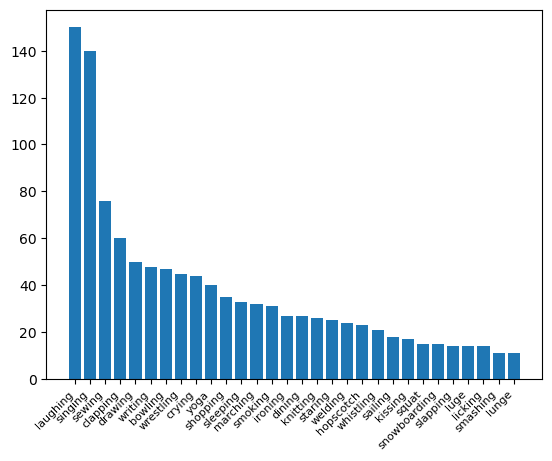

In [17]:
action_idxs = {'staring': {'train': (0, 22), 'val': (0, 3)}, 'laughing': {'train': (22, 158), 'val': (3, 17)}, 'singing': {'train': (158, 285), 'val': (17, 30)}, 'clapping': {'train': (285, 339), 'val': (30, 36)}, 'drawing': {'train': (339, 384), 'val': (36, 41)}, 'wrestling': {'train': (384, 424), 'val': (41, 46)}, 'dining': {'train': (424, 448), 'val': (46, 49)}, 'writing': {'train': (448, 491), 'val': (49, 54)}, 'bowling': {'train': (491, 533), 'val': (54, 59)}, 'squat': {'train': (533, 546), 'val': (59, 61)}, 'slapping': {'train': (546, 558), 'val': (61, 63)}, 'lunge': {'train': (558, 568), 'val': (63, 64)}, 'welding': {'train': (568, 589), 'val': (64, 67)}, 'luge': {'train': (589, 601), 'val': (67, 69)}, 'smashing': {'train': (601, 611), 'val': (69, 70)}, 'shopping': {'train': (611, 642), 'val': (70, 74)}, 'sailing': {'train': (642, 658), 'val': (74, 76)}, 'crying': {'train': (658, 698), 'val': (76, 80)}, 'yoga': {'train': (698, 734), 'val': (80, 84)}, 'sleeping': {'train': (734, 764), 'val': (84, 87)}, 'whistling': {'train': (764, 783), 'val': (87, 89)}, 'licking': {'train': (783, 795), 'val': (89, 91)}, 'knitting': {'train': (795, 818), 'val': (91, 94)}, 'sewing': {'train': (818, 887), 'val': (94, 101)}, 'smoking': {'train': (887, 915), 'val': (101, 104)}, 'snowboarding': {'train': (915, 928), 'val': (104, 106)}, 'marching': {'train': (928, 957), 'val': (106, 109)}, 'hopscotch': {'train': (957, 977), 'val': (109, 112)}, 'kissing': {'train': (977, 992), 'val': (112, 114)}, 'ironing': {'train': (992, 1016), 'val': (114, 117)}}

count_actions = []
for action, idxs in action_idxs.items():
    (train_lo, train_hi), (val_lo, val_hi) = idxs["train"], idxs["val"]
    count_actions.append((train_hi - train_lo + val_hi - val_lo, action))
count_actions.sort(reverse=True)

plt.xticks(rotation=45, ha="right", fontsize=8)
plt.bar([action for _, action in count_actions], [count for count, _ in count_actions])

In [18]:
action_idxs

{'staring': {'train': (0, 22), 'val': (0, 3)}, 'laughing': {'train': (22, 158), 'val': (3, 17)}, 'singing': {'train': (158, 285), 'val': (17, 30)}, 'clapping': {'train': (285, 339), 'val': (30, 36)}, 'drawing': {'train': (339, 384), 'val': (36, 41)}, 'wrestling': {'train': (384, 424), 'val': (41, 46)}, 'dining': {'train': (424, 448), 'val': (46, 49)}, 'writing': {'train': (448, 491), 'val': (49, 54)}, 'bowling': {'train': (491, 533), 'val': (54, 59)}, 'squat': {'train': (533, 546), 'val': (59, 61)}, 'slapping': {'train': (546, 558), 'val': (61, 63)}, 'lunge': {'train': (558, 568), 'val': (63, 64)}, 'welding': {'train': (568, 589), 'val': (64, 67)}, 'luge': {'train': (589, 601), 'val': (67, 69)}, 'smashing': {'train': (601, 611), 'val': (69, 70)}, 'shopping': {'train': (611, 642), 'val': (70, 74)}, 'sailing': {'train': (642, 658), 'val': (74, 76)}, 'crying': {'train': (658, 698), 'val': (76, 80)}, 'yoga': {'train': (698, 734), 'val': (80, 84)}, 'sleeping': {'train': (734, 764), 'val': (

Words: min - 8, max - 69, mean - 14, median - 13, mode - 12
Tokens: min - 8, max - 75, mean - 15, median - 15, mode - 14


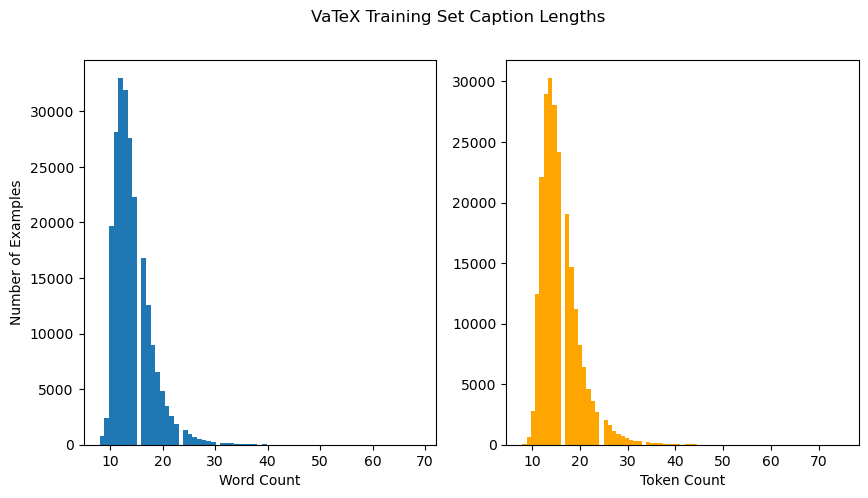

In [39]:
# caption lengths

word_counts, token_counts = [], []
with open("dataset/vatex_train_captions.json") as file:
    for item in json.load(file):
        for caption in item["enCap"]:
            word_counts.append(len(caption.split()))
            token_counts.append(len(tokenizer(caption).input_ids))
            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("VaTeX Training Set Caption Lengths")

ax1.hist(word_counts, bins=max(word_counts))
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Examples")

ax2.hist(token_counts, bins=max(token_counts), color="orange")
ax2.set_xlabel("Token Count")

print("Words: min - %d, max - %d, mean - %d, median - %d, mode - %d" % (min(word_counts), max(word_counts), statistics.mean(word_counts), statistics.median(word_counts), statistics.mode(word_counts)))
print("Tokens: min - %d, max - %d, mean - %d, median - %d, mode - %d" % (min(token_counts), max(token_counts), statistics.mean(token_counts), statistics.median(token_counts), statistics.mode(token_counts)))